In [1]:
from mysql.connector import errorcode
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def connect(host, database, user, password):

    try:
        connection = mysql.connector.connect(host=host, database=database, user=user, password=password)
        if connection != None:
            return connection          
        
    except mysql.connector.Error as error:    
        if error.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database não existe")
                    
        if error.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Usuáro ou  senha  está errado")
            print(error)       
    return 
      
def execute_query(connection, query:str, data:tuple=''):

    try:
        cursor = connection.cursor()
        if data != '':
            cursor.execute(query, data)
            result = cursor.fetchall()
            connection.commit()
        else: 
            cursor.execute(query)
            result = cursor.fetchall()
            connection.commit()
                    
            return result 
    except mysql.connector.Error as error:
        return "Erro: {}".format(error.msg)
    finally:
        if connection.is_connected:
            connection.close()
            
def loop_result(results):
    from_db = []
    
    for result in results:
        result = list(result)
        from_db.append(result)
        
    if from_db != None:
        return from_db
    return

In [3]:
connection = connect('localhost','csgo','root','Database@2023')
query = '''SELECT * FROM results;'''
columns = ["Date_", "team_1", "team_2", "_map", "result_1", "result_2", "map_winner", "starting_ct", "ct_1", "t_2", "t_1", "ct_2", "event_id", "match_id", "rank_1", 
 "rank_2", "map_wins_1", "map_wins_2", "match_winner"]

results_results = execute_query(connection=connection, query=query)
df = pd.DataFrame(loop_result(results_results), columns=columns)
display(df)

,Date_,team_1,team_2,_map,result_1,result_2,map_winner,starting_ct,ct_1,t_2,t_1,ct_2,event_id,match_id,rank_1,rank_2,map_wins_1,map_wins_2,match_winner
0,2020-03-18,Recon 5,TeamOne,Dust2,0,16,2,2,0,1,0,15,5151,2340454,62,63,0,2,2\r
1,2020-03-18,Recon 5,TeamOne,Inferno,13,16,2,2,8,6,5,10,5151,2340454,62,63,0,2,2\r
2,2020-03-18,New England Whalers,Station7,Inferno,12,16,2,1,9,6,3,10,5243,2340461,140,118,12,16,2\r
3,2020-03-18,Rugratz,Bad News Bears,Inferno,7,16,2,2,0,8,7,8,5151,2340453,61,38,0,2,2\r
4,2020-03-18,Rugratz,Bad News Bears,Vertigo,8,16,2,2,4,5,4,11,5151,2340453,61,38,0,2,2\r
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45768,2015-11-05,G2,E-frag.net,Inferno,13,16,2,1,8,7,5,9,1970,2299059,7,16,1,2,2\r
45769,2015-11-05,G2,E-frag.net,Dust2,16,13,1,1,10,5,6,8,1970,2299059,7,16,1,2,2\r
45770,2015-11-04,CLG,Liquid,Inferno,16,12,1,1,7,8,9,4,1934,2299011,10,14,16,12,1\r
45771,2015-11-03,NiP,Dignitas,Train,16,4,1,2,4,1,12,3,1934,2299001,6,12,16,4,1\r


In [4]:
# Gera dois novos DataFrames para os times das colunas "team_1" e "team_2"
df1 = pd.DataFrame(df, columns=['team_1', 'map_wins_1', 'map_wins_2'])
df2 = pd.DataFrame(df, columns=['team_2', 'map_wins_1', 'map_wins_2'])

# Novo dataframe que compara as colunas "map_wins_1" e "map wins_2" para saber em quais casos o time 1 ganhou.
team_1_w = pd.DataFrame(df1.query('map_wins_1 > map_wins_2'), columns=['team_1'])

# Após filtrar as linhas, uma nova variável DataFrame gera uma tabela com o quantitativo de vitórias de cada
# time da coluna "team_1".
count_df1 = team_1_w['team_1'].value_counts().reset_index().rename(columns={'index': 'team_1', 'team_1': 'count'})
display(count_df1)

,team_1,count
0,Astralis,376
1,Liquid,353
2,TYLOO,344
3,Natus Vincere,314
4,Tricked,310
...,...,...
901,Magistra,1
902,walkover,1
903,1UP,1
904,ex-Mentality,1


In [5]:
# Realiza as mesmas operações do notebook acima, só que dessa vez, com a coluna "team_2"
team_2_w = pd.DataFrame(df2.query('map_wins_1 < map_wins_2'), columns=['team_2'])
count_df2 = team_2_w['team_2'].value_counts().reset_index().rename(columns={'index': 'team_2', 'team_2': 'count'})
display(count_df2)

,team_2,count
0,mousesports,277
1,Liquid,266
2,G2,262
3,fnatic,234
4,Spirit,229
...,...,...
931,Wizards,1
932,Normal People and Rustun,1
933,Shadows,1
934,Operation Kino,1


In [6]:
# Concatenar as colunas "team_1" e "team_2" e somar as contagens de vitórias
count_df = pd.concat([count_df1, count_df2], axis=0).groupby('team_1').agg({'count': 'sum'}).reset_index()

# Renomear as colunas do novo DataFrame
count_df.columns = ['team', 'count']

# Somar as contagens de vitórias para cada time
count_df = count_df.groupby('team').agg({'count': 'sum'}).reset_index()

# Ordenar os times pelo número de vitórias
sorted_count_df = count_df.sort_values(by='count', ascending=False)

# Exibir o DataFrame ordenado
display(sorted_count_df)

,team,count
72,Astralis,376
418,Liquid,353
696,TYLOO,344
482,Natus Vincere,314
718,Tricked,310
...,...,...
193,Downfall,1
66,ArkAngel,1
775,WinOut,1
637,Saltbae,1


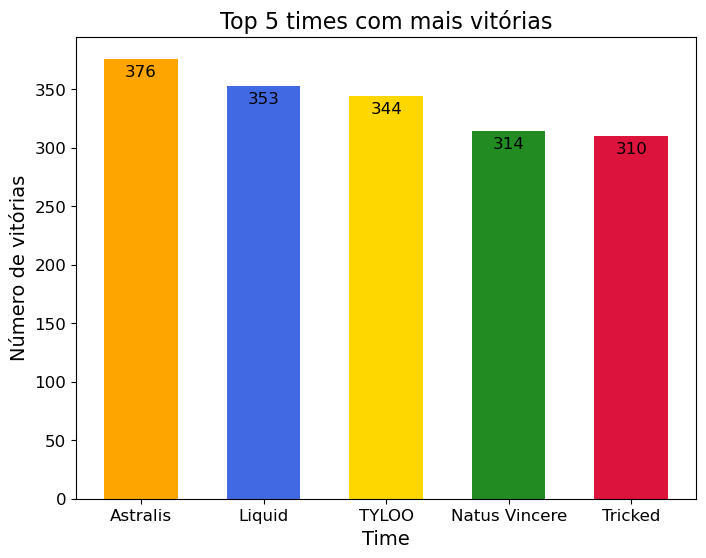

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
bar_container = ax.bar(sorted_count_df['team'].head(5), sorted_count_df['count'].head(5), color=['#FFA500', '#4169E1', '#FFD700', '#228B22', '#DC143C'], width=0.6)
ax.set_title('Top 5 times com mais vitórias', fontsize=16)
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Número de vitórias', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
for i, val in enumerate(sorted_count_df['count'].head(5)):
    ax.text(i, val-15, str(val), ha='center', fontsize=12)
plt.show()